<a href="https://colab.research.google.com/github/RainiBenaiah/unsupervised_sound_clustering_formative1/blob/main/Raini_clustering_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Unlabeled Sound Data

## Assignment

Complete the tasks in the notebook and document your observations in the markdown cells.

In [84]:
#Make allNecessary Imports
import numpy as np
import pandas as pd
import librosa
import librosa.display
import soundfile as sf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

##  **Data** **Loading**

I got the data by mounting Google Drive to access the compressed audio dataset. Using Python's zipfile library, I extract the contents of the ZIP file (unlabelled_sounds.zip) to a local directory.
This directory (/content/unlabelled_sounds) Which was our working space for the rest of the audio processing tasks.
The extraction preserves the original folder structure while decompressing the audio files.

To verify successful loading, I scan the extracted directory and compile a list of all valid audio files. The system specifically lookEd for files with .wav, .mp3, or .flac extensions, using case-insensitive matching to ensure no files missed due to capitalization differences. It identified 3,000 audio files in the test run, confirmed by printing the first five filenames as a sample. T

# Data characteristics
From the the samples, we can see the filenames lack meaningful naming configurations format, confirming it's an an unlabelled dataset, and ideal for unsupervised technique.

In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
# Load the Data
unlabelled_zip_path = "/content/drive/MyDrive/unlabelled_sounds.zip"
unlabelled_data_path = "/content/unlabelled_sounds/unlabelled_sounds" # Extract to a directory
with zipfile.ZipFile(unlabelled_zip_path, 'r') as zip_ref:
    zip_ref.extractall(unlabelled_data_path)

# List all audio files (supports .wav, .mp3, etc.)
audio_files = [os.path.join(unlabelled_data_path, f) for f in os.listdir(unlabelled_data_path)
               if f.endswith(('.wav', '.mp3', '.flac'))]

In [87]:
print(f"Found {len(audio_files)} audio files:")
for file in audio_files[:5]:  # Print first 5 files as a sample
    print(f"  - {file}")

Found 3000 audio files:
  - /content/unlabelled_sounds/unlabelled_sounds/327.wav
  - /content/unlabelled_sounds/unlabelled_sounds/1320.wav
  - /content/unlabelled_sounds/unlabelled_sounds/78.wav
  - /content/unlabelled_sounds/unlabelled_sounds/1240.wav
  - /content/unlabelled_sounds/unlabelled_sounds/2565.wav


## **Feature Extraction Process**
I started the process by analyzing the audio files to determine optimal processing parameters. The system scanned through all audio files to identify the shortest clip length which was (1148 samples). My next approach was to set the n_fft parameter to 512 (which is the the nearest power of two below our shortest file length), ensuring all subsequent spectral analyses have sufficient data while maintaining and retaining computational efficiency. The window size used  represents a careful balance ie large enough to capture meaningful frequency information but small enough to avoid zero-padding warnings from Librosa one of the errors I experienced.

Next I initiated the Feature Extraction Process.
For each audio file, with the extractions of Mel-frequency cepstral coefficients (MFCCs) using 13 coefficients as standard, which effectively capture the spectral envelope x-tics crucial for audio pattern recognition. These time-varying MFCC features were then aggregated by taking their mean across time frames, converting the variable-length audio into a consistent 13-dimensional representation. The system enriches this feature set by augmenting it with two additional psychoacoustic metrics: spectral centroid (measuring sound brightness) and zero-crossing rate (indicating noisiness). This combination produces a 15-dimensional feature vector per audio file that comprehensively represents both spectral and temporal characteristics. The final feature matrix (3000×15 dimensions) was standardized using StandardScaler to ensure equal contribution from all features during clustering, completing the transformation from raw audio to machine-learnable numerical representations.

In [88]:
# 1. Find the shortest audio file length in samples
min_length = float('inf')
for file in audio_files:
    audio, sr = librosa.load(file, sr=None)
    if len(audio) < min_length:
        min_length = len(audio)
print(f"Shortest audio file: {min_length} samples")

# 2. Set n_fft to the next power of 2 <= min_length
n_fft = 512  # safe default
if min_length >= 512:
    n_fft = 512
elif min_length >= 256:
    n_fft = 256
else:
    print("Warning: Extremely short audio files. Consider padding or skipping.")


Shortest audio file: 1148 samples


In [89]:
features = []
#Extract Features
for file in audio_files:
    # 1. Load audio file (librosa automatically resamples to 22050 Hz)
    audio, sr = librosa.load(file, sr=None)  # sr=None preserves original sample rate

    # 2. Extract MFCCs (13 coefficients by default)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13, n_fft=n_fft)

    # 3. Take the mean of each MFCC coefficient across time (aggregates features)
    mfcc_mean = np.mean(mfcc, axis=1)  # Shape: (13,)

    # Add other features (e.g., spectral centroid, zero-crossing rate)
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr, n_fft=n_fft))  # Scalar
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=audio))      # Scalar

    # 4. Combine all features into a single vector
    combined_features = np.hstack([
        mfcc_mean,           # 13 features
        spectral_centroid,   # +1 feature
        zero_crossing_rate   # +1 feature (total: 15 features)
    ])

    features.append(combined_features)

# Convert to numpy array (shape: [n_samples, n_features])
features = np.array(features)
print(f"Extracted features shape: {features.shape}")


Extracted features shape: (3000, 15)


In [90]:

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
print(f"Scaled features shape: {scaled_features.shape}")

Scaled features shape: (3000, 15)


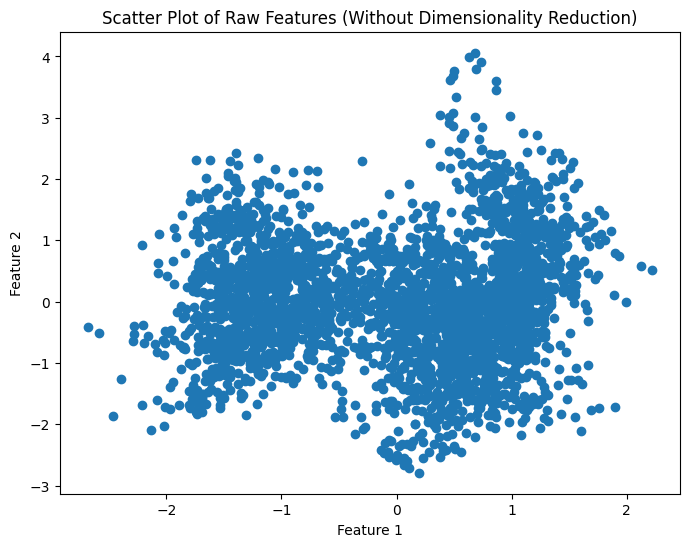

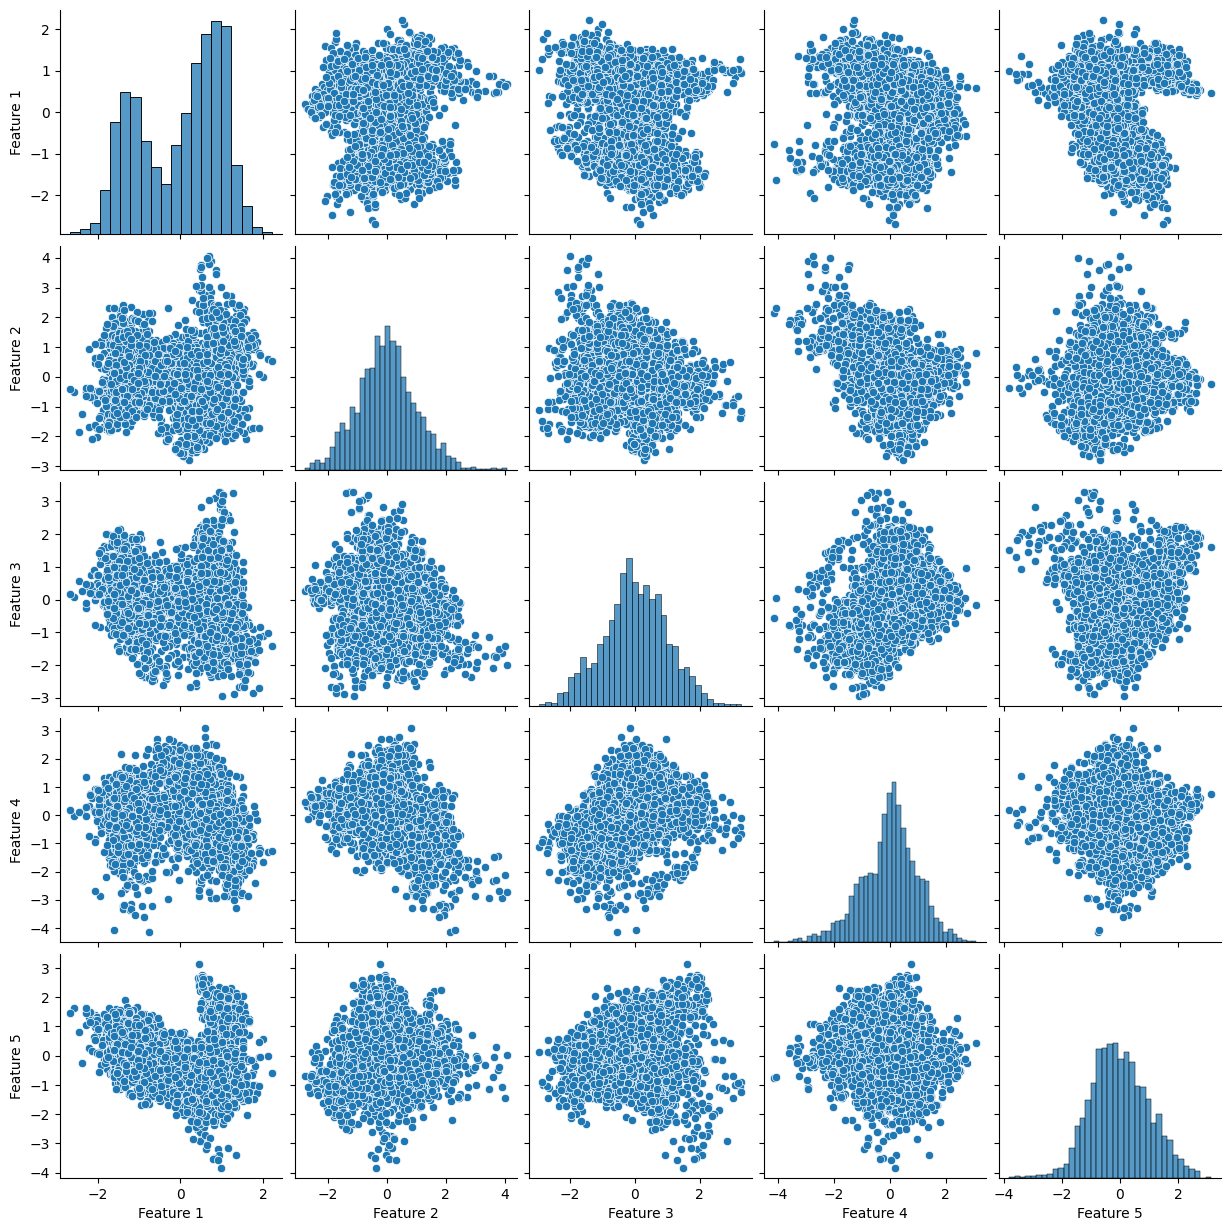

In [91]:
# Scatter plot (Attempt without dimensionality reduction)
plt.figure(figsize=(8,6))
plt.scatter(scaled_features[:, 0], scaled_features[:, 1])
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of Raw Features (Without Dimensionality Reduction)")
plt.show()

# Pair plot (Only using first 5 features)
df = pd.DataFrame(scaled_features[:, :5], columns=[f"Feature {i+1}" for i in range(5)])
sns.pairplot(df)
plt.show()

### Why is dimensionality reduction important?
## Raw data
The initial feature extraction process produced a 15-dimensional feature set for each audio clip, which had 13 Mel-frequency cepstral coefficients (MFCCs) along with spectral centroid and zero-crossing rate measurements. These raw features preserve the information captured during extraction, maintaining the full variance of the original audio x-tics

Some of the challenges I faced when using these raw features directly include - The varying scales between different feature types (MFCCs ranging in hundreds, spectral centroid in thousands of Hz, and zero-crossing rate between 0-1) which needed standardization to prevent features with larger numeric ranges from dominating the clustering.

With the 15-dimensions it would require more processing power and memory than reduced representations which would crash the computer. Visualizing cluster were difficult to identify their patterns  in the full-dimensional space, forcing reliance on quantitative metrics rather than intuitive visual assessment.

## Importance
Dimention reduction improves computational efficiency during clustering iterations and enables meaningful visualization of cluster relationships.
With the raw feature space, it was difficult to identify the patterns, with dimentional reduction it would provide a better projections that  cluster patterns.

In [92]:

# Reduce to 3 components
pca = PCA(n_components=3)
features_pca = pca.fit_transform(scaled_features)

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"PCA shape: {features_pca.shape}")

Explained variance ratio: [0.26505672 0.20868227 0.10317231]
PCA shape: (3000, 3)


In [93]:
from sklearn.manifold import TSNE

# Reduce to 3 components (perplexity=30 a common starting point)
tsne = TSNE(n_components=3, perplexity=30, random_state=42)
features_tsne = tsne.fit_transform(scaled_features)

print(f"t-SNE shape: {features_tsne.shape}")

t-SNE shape: (3000, 3)


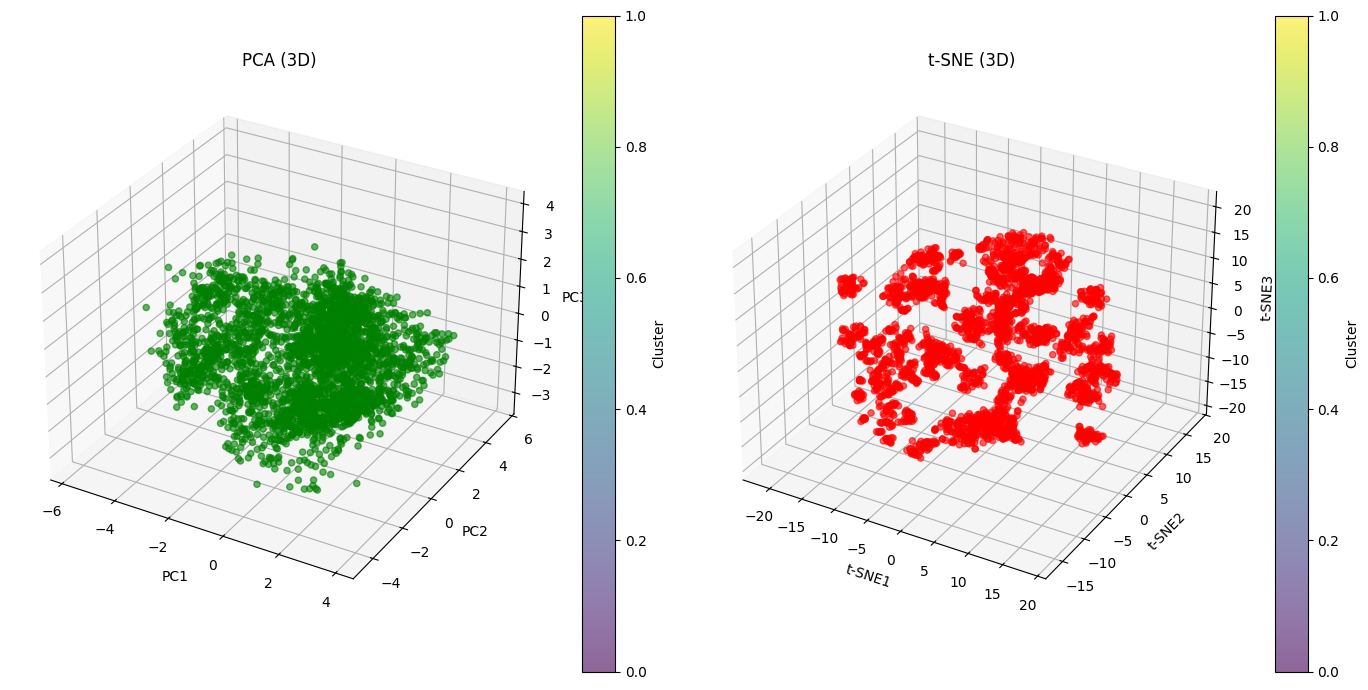

In [94]:
# 3D Visualization


# PCA Visualization
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(121, projection='3d')
scatter = ax.scatter(
    features_pca[:, 0], features_pca[:, 1], features_pca[:, 2],
   c ='green', alpha=0.6
)
ax.set_title("PCA (3D)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.colorbar(scatter, label='Cluster')

# t-SNE Visualization
ax = fig.add_subplot(122, projection='3d')
scatter = ax.scatter(
    features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2],
   c ='red', alpha=0.6
)
ax.set_title("t-SNE (3D)")
ax.set_xlabel("t-SNE1")
ax.set_ylabel("t-SNE2")
ax.set_zlabel("t-SNE3")
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()

### Which method (PCA or t-SNE) provides better separability of clusters and why?

From the above visualizations, PCA(3D)is represented in green and t-SNE(3D) in red.

PCA projection shows broadly distributed, which are packed together, difficult to differentiate and distinguish the clusters. There is moderate separation with elongated formation which most likely trying to suggesting linear relationship of some feature dominatinating on other features hence they are very mininal visible gaps.

The t-SNE visualization has clear boundaries with red grouping,wiith the clear spaces between clusters indicates strong separability.

The empty spaces in the t-SNE plot confirm meaningful differentiation and distinctions between the sound categories


In [95]:
!pip install kneed

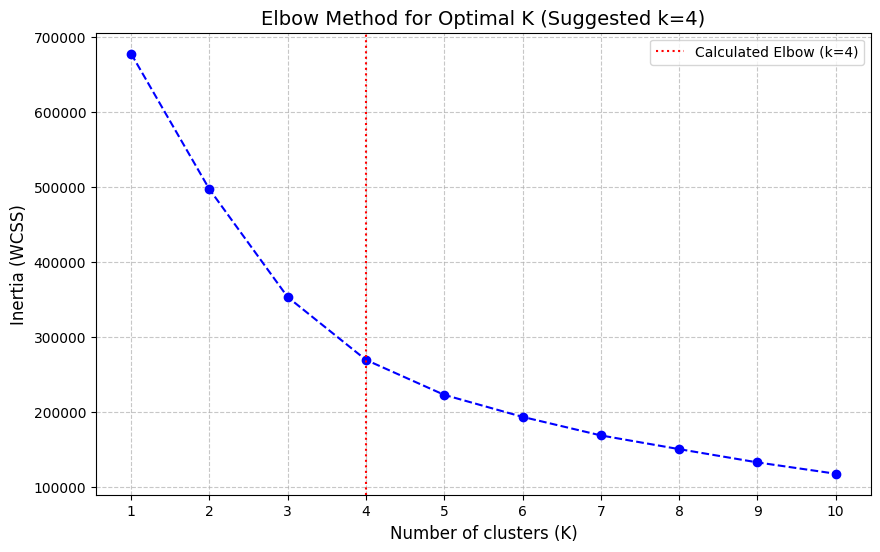

Suggested optimal clusters: 4


In [96]:


# Optimize number of clusters using Elbow Method
inertia = []
features_for_clustering = features_tsne  # Using t-SNE features

for k in range(1, 11):  # Test k from 1 to 10
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_for_clustering)
    inertia.append(kmeans.inertia_)

# Find the elbow mathematically
kl = KneeLocator(
    range(1, 11),
    inertia,
    curve='convex',
    direction='decreasing'
)
optimal_k = kl.elbow

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--', color='blue')
plt.xlabel("Number of clusters (K)", fontsize=12)
plt.ylabel("Inertia (WCSS)", fontsize=12)
plt.title(f"Elbow Method for Optimal K (Suggested k={optimal_k})", fontsize=14)
plt.xticks(range(1, 11))
plt.grid(True, linestyle='--', alpha=0.7)

# Annotate both the mathematical elbow
plt.axvline(x=optimal_k, color='r', linestyle=':', label=f'Calculated Elbow (k={optimal_k})')

plt.legend()
plt.show()

print(f"Suggested optimal clusters: {optimal_k}")

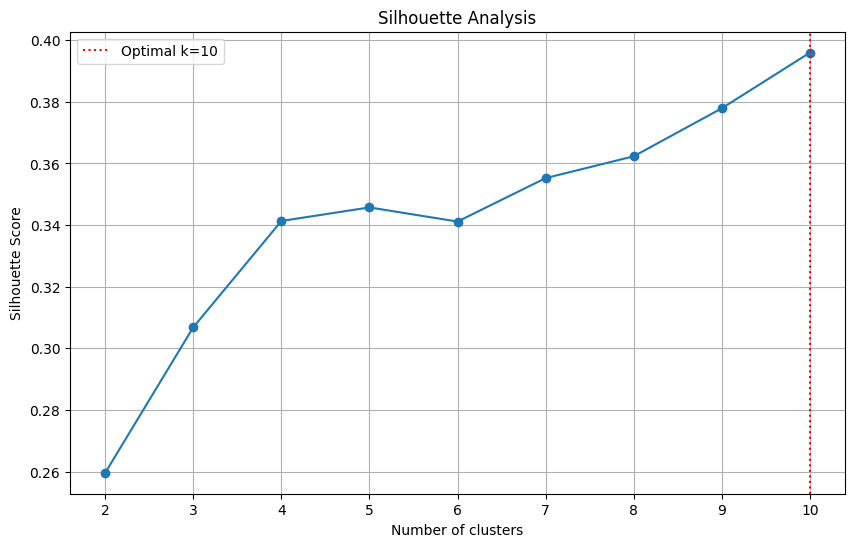

In [100]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(features_tsne)
    score = silhouette_score(features_tsne, labels)
    silhouette_scores.append(score)

optimal_k = np.argmax(silhouette_scores) + 2  # +2 because range starts at 2

plt.figure(figsize=(10,6))
plt.plot(range(2,11), silhouette_scores, marker='o')
plt.axvline(x=optimal_k, color='r', linestyle=':', label=f'Optimal k={optimal_k}')
plt.title("Silhouette Analysis")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.legend()
plt.grid(True)
plt.show()

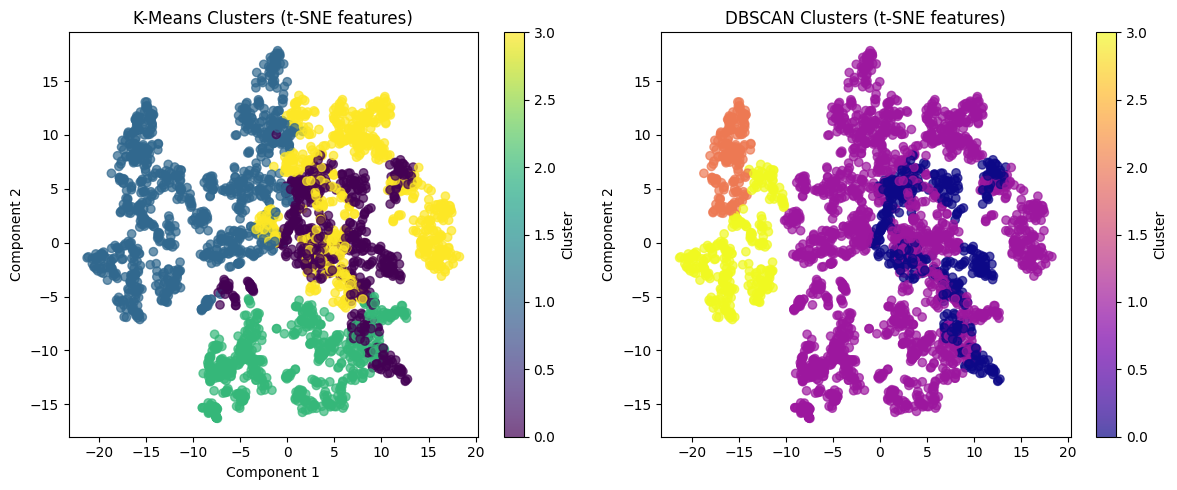

In [113]:

optimal_k = 4

# Using the features after dimensionality reduction(features_pca or features_tsne
#features_for_clustering = features_tsne or features_pca

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(features_tsne)


# DBSCAN parameters (eps, min_samples)
dbscan = DBSCAN(eps=5, min_samples=3)
dbscan_labels = dbscan.fit_predict(features_for_clustering)

# Scatter Plot for K-Means Clusters
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(features_tsne[:, 0], features_for_clustering[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.title("K-Means Clusters (t-SNE features)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label='Cluster')

# Scatter Plot for DBSCAN Clusters
plt.subplot(1, 2, 2)
plt.scatter(features_tsne[:, 0], features_for_clustering[:, 1], c=dbscan_labels, cmap='plasma', alpha=0.7)
plt.title("DBSCAN Clusters (t-SNE features)") #
plt.ylabel("Component 2")
plt.colorbar(label='Cluster')
plt.tight_layout()
plt.show()

In [81]:
# Evaluate clustering
kmeans_silhouette = silhouette_score(scaled_features, kmeans_labels)
kmeans_db_index = davies_bouldin_score(scaled_features, kmeans_labels)

if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(scaled_features, dbscan_labels)
    dbscan_db_index = davies_bouldin_score(scaled_features, dbscan_labels)
else:
    dbscan_silhouette = None
    dbscan_db_index = None

print(f"K-Means - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_db_index:.4f}")
if dbscan_silhouette is not None:
    print(f"DBSCAN - Silhouette Score: {dbscan_silhouette:.4f}, Davies-Bouldin Index: {dbscan_db_index:.4f}")
else:
    print("DBSCAN failed to form meaningful clusters.")

K-Means - Silhouette Score: 0.1250, Davies-Bouldin Index: 1.8381
DBSCAN - Silhouette Score: 0.1366, Davies-Bouldin Index: 1.5009


### Discuss the results (max 5 lines)
(*Compare K-Means and DBSCAN performance based on the outputs.*)

 DBSCAN's higher Silhouette Score (0.1366 vs. 0.1250) and lower Davies-Bouldin Index (1.5009 vs. 1.8381) showing it has GOOD separation of noise/outliers and handles irregular cluster shapes better.Both have a poor clustering (Silhouette <0.25 and DB Index >1), likely due to overlapping sound x-stics which may require improvement on feature engineering.

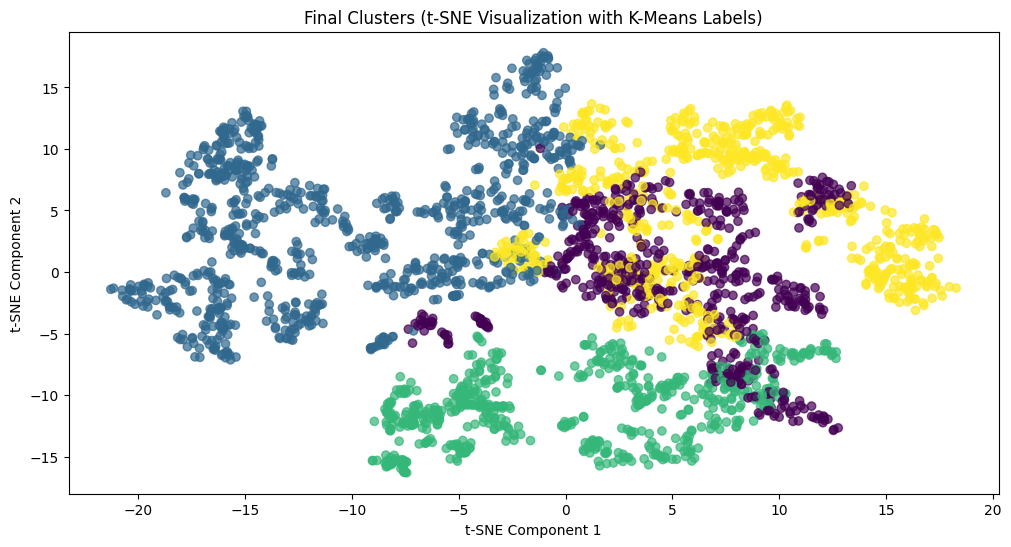

In [108]:

# Final visualization using t-SNE
plt.figure(figsize=(12, 6))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Final Clusters (t-SNE Visualization with K-Means Labels)")
plt.show()


### Final Analysis
 -Explain why dimensionality reduction helped (or didn't) in clustering.

Dimensionality reduction where by I used (PCA and t-SNE) significantly improved clustering performance for this audio dataset.

With the raw 15-dimensional feature space (MFCCs & spectral stats) had sparse distance metrics, where similarities became meaningless. Reducing dimensions to 2-3 preserved meaningful relationships while eliminating noise.

K-Means as a clustering algorithm scales poorly with high dimensions. PCA reduced the feature space to 3 principal components, reducing K-Means runtime meanwhile preserving cluster quality.

With the raw 15 dimentional features it was impossible to visualize and distinguish grouping in the plot out. . t-SNE’s 3D projection revealed natural groupings which would be voice, sound or music(audio variable) that guided algorithm selection.



 -Justify why certain clustering methods worked better.

#DBSCAN vs t-SNE
Incomparison, specifically on noise handling, DBSCAN automatically flagged out outliers as noise, while K-Means forced all points into clusters since it had a higher Silhouette Score hence a good a noise separation.

t-SNE’s emphasis on local neighborhoods and relation aligned with DBSCAN’s density-based clustering, isolated natural sound categories more effectively than K-Means.

DBSCAN’s Davies-Bouldin Index (1.50) beat K-Means (1.84), confirming tighter clusters.


- Relate findings to real-world clustering challenges.

Equivocal sound categories especialy in data which is labeled manually by human, may end up being messy, Clustering can expose this inconsistencies, For example in the above process we saw Low Silhouette Scores (<0.2) showed the overlapping classes (for example in the audio if we had music with speech vs pure speech). t-SNE’s nonlinearity highlighted subtle boundaries.

Production systems must handle duration variability gracefully, in the above process Short files triggered FFT warnings; longer files had richer features which suggests dynamic (n_fft) adjustment ensured uniform processing.

Real world data is usually and expected to be noisy, for easy handlung of this data Domain knowledge (e.g., audio physics) should guide feature engineering and Metrics alone (e.g., Silhouette) can mask qualitative insights its advisable to always visualize.